# **To Access the required folder to run this document, use this link**
https://drive.google.com/drive/folders/1aeVlY2RSaNwhLbYkQDRhV9KYDDI9V8hX?usp=drive_link

# Filtering RFD2 outputs using PyRosetta and Biotite

You will find that many (most) of the backbones RF-diffusion 2 outputs is not suitable for sequence design. Common problems we see with the generated structures include:

**Chain breaks**\
**Insufficient interactions with ligand**\
**Unrealistic sidechains**\
**Unrealistically long helices**


In [1]:
import os, sys
import glob
from google.colab import drive
import tarfile
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pyrosettacolabsetup py3dmol biotite


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 MB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 84.4 MB/s eta 0:00:00


In [3]:
rfd2_dir = '/content/drive/MyDrive/rfd2/' #make sure this is correct!

In [13]:
os.environ['PYTHONPATH'] += ":/content/drive/MyDrive/rfd2"
sys.path.append(rfd2_dir)

In [4]:
!pip install -e /content/drive/MyDrive/rfd2/

Obtaining file:///content/drive/MyDrive/rfd2
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Installing backend dependencies ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for rf_diffusion (pyproject.toml) ... done
  Created wheel for rf_diffusion: filename=rf_diffusion-0.0.0-py3-none-any.whl size=2010 sha256=c7b442842808bb6e678ff0e9049ebaf54a17cf541a8a1197f5993b1478022bb6
  Stored in directory: /tmp/pip-ephem-wheel-cache-4vdokwiz/wheels/49/1c/ac/c5f716f79e4d53e36b0caaa008ed342904a090d40e72e6f30d
Successfully built rf_diffusion


In [5]:
import pyrosettacolabsetup; pyrosettacolabsetup.install_pyrosetta()

Mounted at /content/google_drive

Note that USE OF PyRosetta FOR COMMERCIAL PURPOSES REQUIRE PURCHASE OF A LICENSE.
See https://github.com/RosettaCommons/rosetta/blob/main/LICENSE.md or email license@uw.edu for details.

Looking for compatible PyRosetta wheel file at google-drive/PyRosetta/colab.bin//wheels...
Found compatible wheel: /content/google_drive/MyDrive/PyRosetta/colab.bin/wheels//content/google_drive/MyDrive/PyRosetta/colab.bin/wheels/pyrosetta-2025.43+release.b230e431d8-cp312-cp312-linux_x86_64.whl




In [6]:
#sometimes the above line does weird things - make sure you are mounted into /content/drive/
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
os.chdir('/content/drive/MyDrive/enzdes_rfd2_tutorial/') #make sure this is the correct path!
working_dir = '/content/drive/MyDrive/enzdes_rfd2_tutorial'
rfd2_pdbdir = f'{working_dir}/examples_for_pyrosetta_filtering'
os.path.exists(rfd2_pdbdir)

True

In [8]:
#Extract example rfd2 pdb files for filtering

tar_path = f'{working_dir}/examples_for_pyrosetta_filtering.tar.gz'
extract_path = f'{working_dir}/examples_for_pyrosetta_filtering'

# Extract
with tarfile.open(tar_path, "r:gz") as tar:  # use "r:" for plain .tar
    tar.extractall(path=extract_path)
    print(f"Extracted to {extract_path}")

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/clean_enzdes_rfd2_tutorial/examples_for_pyrosetta_filtering.tar.gz'

In [22]:
import pickle
from pyrosetta import *
from pyrosetta.rosetta import *
import pyrosetta.rosetta.core.scoring.dssp as dssp
from pyrosetta.rosetta.core.scoring import score_type_from_name
from pyrosetta.rosetta.protocols.analysis import InterfaceAnalyzerMover
from pyrosetta.rosetta.core.scoring.sasa import SasaCalc

import biotite
import biotite.structure.io.pdb as Pdb
from collections import defaultdict, Counter
from scipy.spatial import cKDTree
import numpy as np
import pandas as pd
import math
import py3Dmol
import rf_diffusion
import matplotlib.pyplot as plt
import seaborn as sns

In [69]:
def show_pdb_simple(pdb_path):
  with open(pdb_path, 'r') as f:
    pdb_data = f.read()

    view = py3Dmol.view(width=600, height=400)
    view.addModel(pdb_data, 'pdb')
    view.setStyle({'cartoon': {'color': 'spectrum'}})
    view.addStyle({'and': [
    {'resn': ['ALA','VAL','LEU','ILE','PHE','TYR','TRP','SER','THR','ASN','GLN','ASP','GLU','LYS','ARG','HIS','CYS','MET','PRO','GLY']}
]}, {'stick': {}})

# Sticks for ligands (anything that’s not a standard residue)
    view.addStyle({'hetflag': True}, {'stick': {'colorscheme': 'greenCarbon'}})
    view.addStyle({'atom': 'ZN'}, {'sphere': {'color': 'silver', 'radius': 1.0}})

    view.zoomTo()
    view.show()

# I. Make functions for filtering

In [15]:
#obtains where in the sequence your theozyme residues are
def get_input_residues(trb):
    with open(trb, 'rb') as f:
        data = pickle.load(f)
        resis = data['con_hal_pdb_idx']
        resis = [int(i[1]) for i in resis]
        return resis


In [16]:
#use pyrosetta to get ROG, secondary structure, and backbone+sidechain quality

#The function below
def get_rosetta_scores(pose, sfx, sfx_cart, catres_list):
    """
    Getting sidechain quality scores for a given pose.
    Inspired by Florence Hardy and Aiko Muraishi
    """
    sfx(pose)
    sfx_cart(pose)

    scoredict = {}
    for k in ["cart_bonded", "fa_dun"]:
        scoredict[k] = {
        res.seqpos(): pose.energies().residue_total_energies(res.seqpos()).get(score_type_from_name(k))
        for res in pose.residues if res.seqpos() in catres_list}

    averages = {k: np.average(list(scores.values())) for k,scores in scoredict.items()}

    return averages, scoredict

def get_ROG(pose):
    centroid = np.array([np.average([res.xyz("CA").__getattribute__(c) for res in pose.residues if res.is_protein()]) for c in "xyz"])
    ROG = max([np.linalg.norm(centroid - res.xyz("CA")) for res in pose.residues if res.is_protein()])
    return ROG


def res_on_loop(secstruct, seq, resis): #how many catalytic residues were placed on a loop?
    c = 0
    for resi in resis:
        if secstruct[resi] == 'L':
            c+=1
    return c

def longest_helix(secstruct): #sometimes rfd2 makes backbones with unrealistically long helices
    if 'H' in secstruct:
        longest_helix = max([len(x.replace("E", "")) for x in secstruct.split("L") if "H" in x])
    else:
        longest_helix = 0
    return longest_helix

def get_SASA(pose):
    #get ligand index
    ligand_indices = [i for i in range(1, pose.size()+1) if pose.residue(i).is_ligand()]
    #make ligand only pose
    ligand_residue = pose.residue(ligand_indices[0])
    ligand_pose = Pose()
    ligand_pose.append_residue_by_jump(ligand_residue, 1)

    #setup sasa calc
    sasa_calc = rosetta.core.scoring.sasa.SasaCalc()
    # typical probe radius 1.4 A
    sasa_calc.set_probe_radius(1.4)
    # perform calculations
    sasa_calc.calculate(pose)
    rsd_sasa_full = sasa_calc.get_residue_sasa()   # utility.vector1_double, 1-based indexing

    sasa_calc.calculate(ligand_pose)
    rsd_sasa_free = sasa_calc.get_residue_sasa()

    # sum ligand residues in full pose (non-protein residues)
    total_bound_sasa = 0.0
    for i in range(1, pose.total_residue() + 1):
        res = pose.residue(i)
        if not res.is_protein():
            # vector1_double is 1-based; convert via [i]
            try:
                total_bound_sasa += float(rsd_sasa_full[i])
            except Exception:
                # if value missing or -1, skip
                pass

    # sum free ligand sasa (all residues in pose_lig should be ligand residues)
    total_free_sasa = 0.0
    for i in range(1, ligand_pose.total_residue() + 1):
        try:
            total_free_sasa += float(rsd_sasa_free[i])
        except Exception:
            pass

        # safety: if total_free_sasa is zero or nan, return nan (same semantics as original)
    if total_free_sasa == 0 or np.isnan(total_free_sasa):
        return np.nan

    return float(total_bound_sasa / total_free_sasa)

**What is ligand SASA?**\
SASA: solvent accessible surface area\
ligand SASA: a measure of how buried/exposed a ligand is\
calculated by: \
relative ligand SASA (calculated here):\
(SASA of ligand bound to protein)/(SASA of free ligand)

**How is sidechain quality being measured?**\
In this code, I am using items from Rosetta's score function to measure sidechain "quality"\
**fa_dun**:\
Uses the Dunbrack library to score sidechain rotamers\
**cart_bonded**:\
Metric of bond lengths/angles/torsions\
There is probably better ways of doing this with pyrosetta, and if you have a way you prefer go ahead and try implementing it later!  


In [17]:
#Using biotite to get chain breaks and clashes

BREAK_CUTOFF = 2.4
STANDARD_ATOM_NAMES = {
    "N", "CA", "C", "O", "CB",
    "CG", "CD", "CE", "NZ", "OG", "SG",
    "OD1", "OD2", "OE1", "OE2",
    "ND1", "ND2", "NE", "NE1", "NE2",
    "SD", "CE1", "CE2", "CE3",
    "CZ", "CZ2", "CZ3", "CH2",
    "NH1", "NH2", "OH", "OG1",
    "CD1", "CD2", "CG1", "CG2",
    "ND3", "OXT", "H", "HA", "HB", "HG", "HD", "HE", "HH"
}


def get_atom_array(pdb):
    pdb_file = Pdb.PDBFile.read(pdb)
    atom_array = Pdb.get_structure(pdb_file, model=1, altloc='occupancy')
    return atom_array

def clean_atom_array(atom_array):
    """For UNK residues keep only standard atom names; otherwise keep all atoms."""
    is_unk = atom_array.res_name == "UNK"
    is_standard_atom = np.isin(atom_array.atom_name, list(STANDARD_ATOM_NAMES))
    keep_mask = (~is_unk) | (is_unk & is_standard_atom)
    return atom_array[keep_mask]


def chain_break_check(atm_array):
    """Return True if there's any chain break (distance between C(i) and N(i+1) > BREAK_CUTOFF)."""
    is_bb = np.isin(atm_array.atom_name, ["N", "C"])
    is_prot = np.isin(atm_array.res_name, [
        "ALA","CYS","ASP","GLU","PHE","GLY","HIS",
        "ILE","LYS","LEU","MET","ASN","PRO","GLN",
        "ARG","SER","THR","VAL","TRP","TYR"
    ])
    bb_atoms = atm_array[is_bb & is_prot]

    backbone_map = defaultdict(dict)
    for atom in bb_atoms:
        key = (atom.chain_id, int(atom.res_id))
        backbone_map[key][atom.atom_name] = atom.coord

    # iterate by chain
    chains = sorted(set(ch for ch, res in backbone_map.keys()))
    for chain in chains:
        res_ids = sorted(res for ch, res in backbone_map.keys() if ch == chain)
        for i in range(len(res_ids) - 1):
            r1 = res_ids[i]
            r2 = res_ids[i+1]
            c_coord = backbone_map[(chain, r1)].get("C")
            n_coord = backbone_map[(chain, r2)].get("N")
            if c_coord is None or n_coord is None:
                return True
            if np.linalg.norm(c_coord - n_coord) > BREAK_CUTOFF:
                return True
    return False


Below I will make an empty dictionary to store the data from our rfd2 outputs.

# Part II. Collecting metrics and analyzing data


In [57]:
#make an empty dictionary to store metrics from rfd2 outputs

dic = {'pdb path':[],
       'pdb': [],
       'fixed residues': [],
       'chain break': [],
       'num on loop': [],
       'rog' : [],
       'loop frac': [],
       'helix frac': [],
       'cart bonded': [],
       'fa dun': [],
       'worst cart': [],
       'worst fa': [],
       'longest helix': [],
       'ligand SASA':[]
      }

In [58]:
trbs = glob.glob(f'{rfd2_pdbdir}/*trb')
params_file = f'{working_dir}/theozymes/QA0.params'
os.path.exists(params_file)

False

In [59]:
pyrosetta.init(f'-extra_res_fa {params_file} -mute all')
sfx = pyrosetta.get_fa_scorefxn()
sfx_cart = sfx.clone()
sfx_cart.set_weight(score_type_from_name("cart_bonded"), 0.5)
sfx_cart.set_weight(score_type_from_name("pro_close"), 0.0)
for trb in trbs:
    pdb = trb.replace('.trb', '.pdb')
    dic['pdb path'].append(pdb)
    dic['pdb'].append(pdb.split('/')[-1])
    input_residues = get_input_residues(trb)
    dic['fixed residues'].append(" ".join("A" + str(i) for i in input_residues))
    atm_array = get_atom_array(pdb)
    atm_array = clean_atom_array(atm_array)
    dic['chain break'].append(chain_break_check(atm_array))
    pose = pose_from_pdb(pdb)
    dic['rog'].append(get_ROG(pose))
    dssp = pyrosetta.rosetta.core.scoring.dssp.Dssp(pose)
    secstruct = dssp.get_dssp_secstruct()
    seq = pose.sequence()
    dic['num on loop'].append(res_on_loop(secstruct, seq, input_residues))
    dic['longest helix'].append(longest_helix(secstruct))
    dic['loop frac'].append(secstruct.count("L") / pose.size())
    dic['helix frac'].append(secstruct.count("H") / pose.size())
    averages, scoredict = get_rosetta_scores(pose, sfx, sfx_cart, input_residues)
    dic['cart bonded'].append(averages['cart_bonded'])
    dic['fa dun'].append(averages['fa_dun'])
    dic['worst cart'].append(max([scoredict['cart_bonded'][k] for k in scoredict['cart_bonded']]))
    dic['worst fa'].append(max([scoredict['fa_dun'][k] for k in scoredict['fa_dun']]))
    dic['ligand SASA'].append(get_SASA(pose))

┌───────────────────────────────────────────────────────────────────────────────┐
│                                  PyRosetta-4                                  │
│               Created in JHU by Sergey Lyskov and PyRosetta Team              │
│               (C) Copyright Rosetta Commons Member Institutions               │
│                                                                               │
│ NOTE: USE OF PyRosetta FOR COMMERCIAL PURPOSES REQUIRES PURCHASE OF A LICENSE │
│          See LICENSE.PyRosetta.md or email license@uw.edu for details         │
└───────────────────────────────────────────────────────────────────────────────┘
PyRosetta-4 2025 [Rosetta PyRosetta4.MinSizeRel.python312.ubuntu 2025.43+release.b230e431d8ef0bcdea01dbb0065ca62c7dd694ad 2025-10-15T17:07:03] retrieved from: http://www.pyrosetta.org


In [60]:
df = pd.DataFrame(dic)

## What is good? What do our metrics mean?

"Good" metrics will be relative to the design problem. One way of determining which designs are good is to look at the distribution of a certain metric.

In [25]:
def show_histplot(df, metric):
  sns.histplot(df[metric])
  plt.show()

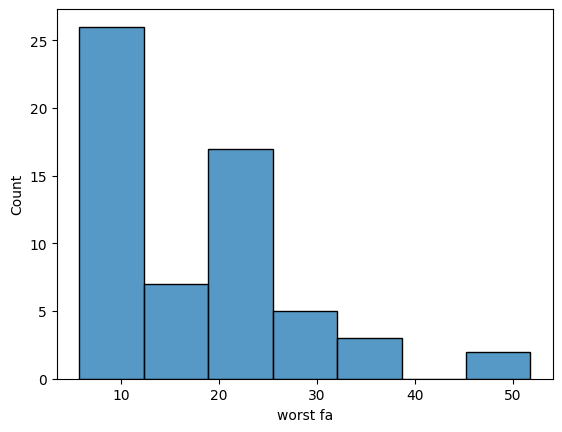

In [30]:
show_histplot(df, 'worst fa')

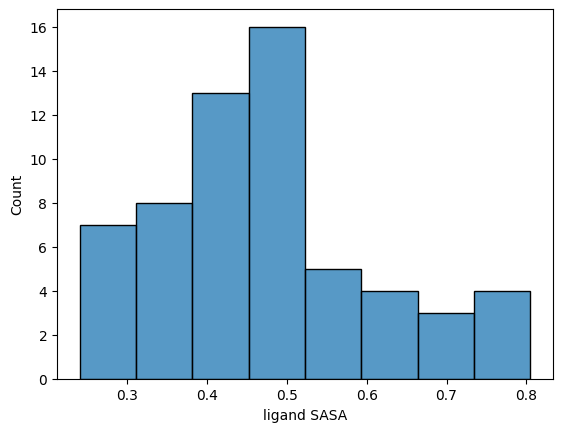

In [27]:
show_histplot(df, 'ligand SASA')

## But again - what do the metrics actually mean?

The code below parses through our dataframe and displays a given design with its metrics. This can help you get a feel for what certain metrics mean, and what your cutoffs should be.

**Look at different designs by changing the value of i at the top of the code below**

In [31]:
i = 29 #change this value to see different designs!!!
pdb_path = df.iloc[i]['pdb path']
with open(pdb_path, 'r') as f:
    pdb_data = f.read()
view = py3Dmol.view(width=600, height=400)
view.addModel(pdb_data, 'pdb')
view.setStyle({'cartoon': {'color': 'spectrum'}})
view.addStyle({'and': [
    {'resn': ['ALA','VAL','LEU','ILE','PHE','TYR','TRP','SER','THR','ASN','GLN','ASP','GLU','LYS','ARG','HIS','CYS','MET','PRO','GLY']}
]}, {'stick': {}})

# Sticks for ligands (anything that’s not a standard residue)
view.addStyle({'hetflag': True}, {'stick': {'colorscheme': 'greenCarbon'}})
view.addStyle({'atom': 'ZN'}, {'sphere': {'color': 'silver', 'radius': 1.0}})

print(f'pdb: {df.iloc[i]["pdb"]}')
print(f'SASA: {df.iloc[i]["ligand SASA"]}')
print(f'ROG: {df.iloc[i]["rog"]}')
print(f'loop: {df.iloc[i]["loop frac"]} \t helix: {df.iloc[i]["helix frac"]} \t sheet: {1-df.iloc[i]["loop frac"]-df.iloc[i]["helix frac"]}')

view.zoomTo()
view.show()

pdb: 1qji_theozyme_HEHHMY_ORI_81_LENGTH_120_140_tutorial_t1_1_2-atomized-bb-False.pdb
SASA: 0.8011880679814892
ROG: 25.457058092271748
loop: 0.13076923076923078 	 helix: 0.8692307692307693 	 sheet: 0.0


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Below I filter the outputs of the pandas dataframe based on the value of metrics. Change these values as you see fit!

In [35]:
filtered = df.loc[df['chain break'] == False]
filtered = filtered.loc[filtered['num on loop'] <= 2]
filtered = filtered.loc[filtered['longest helix'] < 35]
filtered = filtered.loc[filtered['ligand SASA'] < 0.5]
filtered = filtered.loc[filtered['ligand SASA'] > 0.3]
filtered = filtered.loc[filtered['loop frac'] <= 0.2]


print(f'Number of designs in filtered subset: {filtered.shape[0]}')

Number of designs in filtered subset: 29


In [ ]:
i = 2 #Change this value to look at different pdbs!
pdb_path = filtered.iloc[i]['pdb path']
with open(pdb_path, 'r') as f:
    pdb_data = f.read()
view = py3Dmol.view(width=600, height=400)
view.addModel(pdb_data, 'pdb')
view.setStyle({'cartoon': {'color': 'spectrum'}})
view.addStyle({'and': [
    {'resn': ['ALA','VAL','LEU','ILE','PHE','TYR','TRP','SER','THR','ASN','GLN','ASP','GLU','LYS','ARG','HIS','CYS','MET','PRO','GLY']}
]}, {'stick': {}})

# Sticks for ligands (anything that’s not a standard residue)
view.addStyle({'hetflag': True}, {'stick': {'colorscheme': 'greenCarbon'}})
view.addStyle({'atom': 'ZN'}, {'sphere': {'color': 'silver', 'radius': 1.0}})

print(f'pdb: {filtered.iloc[i]["pdb"]}')
print(f'SASA: {filtered.iloc[i]["ligand SASA"]}')
print(f'ROG: {filtered.iloc[i]["rog"]}')
print(f'loop: {filtered.iloc[i]["loop frac"]} \t helix: {filtered.iloc[i]["helix frac"]} \t sheet: {1-filtered.iloc[i]["loop frac"]-filtered.iloc[i]["helix frac"]}')

view.zoomTo()
view.show()

pdb: 1qji_theozyme_HEHHMY_ORI_102_LENGTH_200_220_tutorial_t1_1_1-atomized-bb-False.pdb
SASA: 0.4951705295188125
ROG: 25.29791983200225
loop: 0.1650485436893204 	 helix: 0.7669902912621359 	 sheet: 0.06796116504854366


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

## III. Running ligandMPNN

Let's say we decided on the best metrics to use, and now we want to run sequence design

In [61]:
filtered = df.loc[df['chain break'] == False]
filtered = filtered.loc[filtered['num on loop'] <= 2]
filtered = filtered.loc[filtered['longest helix'] < 35]
filtered = filtered.loc[filtered['ligand SASA'] < 0.5]
filtered = filtered.loc[filtered['ligand SASA'] > 0.3]
filtered = filtered.loc[filtered['loop frac'] <= 0.2]
filtered = filtered.loc[filtered['worst fa'] <= 10]
filtered = filtered.loc[filtered['worst cart'] <= 10]


print(f'Number of designs in filtered subset: {filtered.shape[0]}')

Number of designs in filtered subset: 17


### Download/Install/Setup  ligandMPNN

In [37]:
# ================================
# SYSTEM SETUP AND DEPENDENCIES
# ================================

# Check if running in Colab
try:
    import google.colab
    IN_COLAB = True
    print("✓ Running in Google Colab")
except ImportError:
    IN_COLAB = False
    print("✗ Not running in Google Colab")

# Mount Google Drive for persistent storage
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

# ================================
# MICROMAMBA ENVIRONMENT SETUP
# ================================
# Install micromamba in Google Colab
!wget -qO- https://micro.mamba.pm/api/micromamba/linux-64/latest | tar -xvj bin/micromamba

# Make it easier to call
!mkdir -p /usr/local/bin
!mv bin/micromamba /usr/local/bin/micromamba

# Initialize micromamba shell (bash)
#!micromamba shell init -s bash  ~/micromamba

✓ Running in Google Colab
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
bin/micromamba


In [45]:
# ================================
# LIGANDMPNN SETUP
# ================================
%cd /content
!git clone https://github.com/dauparas/LigandMPNN.git
%cd LigandMPNN
!bash get_model_params.sh "./model_params"

!micromamba create -y -n ligandmpnn -c conda-forge -c bioconda tmalign  python=3.11 git

!micromamba run -n ligandmpnn pip install -r requirements.txt
%cd /content

print("✓ LigandMPNN setup complete")

/content
Cloning into 'LigandMPNN'...
remote: Enumerating objects: 338, done.
remote: Counting objects: 100% (162/162), done.
remote: Compressing objects: 100% (63/63), done.
remote: Total 338 (delta 120), reused 99 (delta 99), pack-reused 176 (from 1)
Receiving objects: 100% (338/338), 2.64 MiB | 17.22 MiB/s, done.
Resolving deltas: 100% (133/133), done.
/content/LigandMPNN
conda-forge/linux-64                                        Using cache
conda-forge/noarch                                          Using cache
bioconda/linux-64                                           Using cache
bioconda/noarch                                             Using cache


Transaction

  Prefix: /root/.local/share/mamba/envs/ligandmpnn

  Updating specs:

   - tmalign
   - python=3.11
   - git


  Package                  Version  Build               Channel           Size
────────────────────────────────────────────────────────────────────────────────
  Install:
────────────────────────────────────

In [62]:
working_dir = '/content/drive/MyDrive/enzdes_rfd2_tutorial'
mpnn_outdir = f'{working_dir}/outputs/ligandMPNN'
if not os.path.exists(mpnn_outdir):
    os.makedirs(mpnn_outdir)


A few useful flags for ligandMPNN\
--omit_aa tells mpnn not to put certain residues in the sequence (e.g --omit_aa "CH")\
--fixed_residues tells mpnn which residues not to design (e.g --fixed_res "A91 A102")\
--repack_everything 0 should tell mpnn not to repack your fixed residues (keep designed rotamers)

In [63]:
l = filtered.shape[0]
omit = 'CH'
num_des = 1
for i in range(l):
  pdb = filtered.iloc[i]['pdb path']
  fixed_residues = filtered.iloc[i]['fixed residues']
  cmd = f'!micromamba run -n ligandmpnn python /content/LigandMPNN/run.py \
    --model_type ligand_mpnn --pdb_path {pdb} --out_folder {mpnn_outdir} \
    --pack_side_chains 1 --number_of_batches {num_des} --temperature 0.2 --omit_AA {omit} \
    --repack_everything 0  --fixed_residues "{fixed_residues}" \
    --checkpoint_path_sc /content/LigandMPNN/model_params/ligandmpnn_sc_v_32_002_16.pt \
    --checkpoint_ligand_mpnn /content/LigandMPNN/model_params/ligandmpnn_v_32_010_25.pt \n'
print(cmd)

!micromamba run -n ligandmpnn python /content/LigandMPNN/run.py     --model_type ligand_mpnn --pdb_path /content/drive/MyDrive/clean_enzdes_rfd2_tutorial/examples_for_pyrosetta_filtering/1qji_theozyme_HEHHMY_ORI_81_LENGTH_120_140_tutorial_t1_1_3-atomized-bb-False.pdb --out_folder /content/drive/MyDrive/enzdes_rfd2_tutorial/outputs/ligandMPNN     --pack_side_chains 1 --number_of_batches 1 --temperature 0.2 --omit_AA CH     --repack_everything 0  --fixed_residues "A20 A21 A24 A74 A105"     --checkpoint_path_sc /content/LigandMPNN/model_params/ligandmpnn_sc_v_32_002_16.pt     --checkpoint_ligand_mpnn /content/LigandMPNN/model_params/ligandmpnn_v_32_010_25.pt 



In [64]:
!micromamba run -n ligandmpnn python /content/LigandMPNN/run.py     --model_type ligand_mpnn --pdb_path /content/drive/MyDrive/clean_enzdes_rfd2_tutorial/examples_for_pyrosetta_filtering/1qji_theozyme_HEHHMY_ORI_81_LENGTH_120_140_tutorial_t1_1_3-atomized-bb-False.pdb --out_folder /content/drive/MyDrive/enzdes_rfd2_tutorial/outputs/ligandMPNN     --pack_side_chains 1 --number_of_batches 1 --temperature 0.2 --omit_AA CH     --repack_everything 0  --fixed_residues "A20 A21 A24 A74 A105"     --checkpoint_path_sc /content/LigandMPNN/model_params/ligandmpnn_sc_v_32_002_16.pt     --checkpoint_ligand_mpnn /content/LigandMPNN/model_params/ligandmpnn_v_32_010_25.pt


/root/.local/share/mamba/envs/ligandmpnn/lib/python3.11/site-packages/prody/utilities/misctools.py:424: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Designing protein from this path: /content/drive/MyDrive/clean_enzdes_rfd2_tutorial/examples_for_pyrosetta_filtering/1qji_theozyme_HEHHMY_ORI_81_LENGTH_120_140_tutorial_t1_1_3-atomized-bb-False.pdb
These residues will be redesigned:  ['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15', 'A16', 'A17', 'A18', 'A19', 'A22', 'A23', 'A25', 'A26', 'A27', 'A28', 'A29', 'A30', 'A31', 'A32', 'A33', 'A34', 'A35', 'A36', 'A37', 'A38', 'A39', 'A40', 'A41', 'A42', 'A43', 'A44', 'A45', 'A46', 'A47', 'A48', 'A49', 'A50', 'A51', 'A52', 'A53', 'A54', 'A55', 'A56', 'A57', 'A58', 'A59', 'A60', 'A61',

In [71]:
ligandmpnn_packed = glob.glob(f'{mpnn_outdir}/packed/*pdb')

In [70]:
show_pdb_simple(ligandmpnn_packed[0])

3Dmol.js failed to load for some reason. Please check your browser console for error messages.